# Fundamentos de Ciência de Dados

Work made by:
- João António, nº 76558, joaoantonio@ua.pt, Mestrado em ciência de dados (9306)
- Tiago Freitas, nº 76748, tiagofreitas79@ua.pt, Mestrado em ciência de dados (9306)

## Organizações não governamentais de ambiente por 100 000 habitantes (N.º) por Localização geográfica (NUTS - 2013); Anual
https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0008290&contexto=bd&selTab=tab2

### Base de dados: Nuts 2013

### Sinais convencionais
Sinais convencionais por ausência de valor
- `…`	Dado confidencial
- `-`	Dado nulo ou não aplicável
- `x`	Dado não disponível
- `o`	Dado inferior a metade do módulo da unidade utilizada
- `∞`	Infinito

Sinais convencionais adicionais ao valor
- `//` Dado preliminar
- `&`	Dado provisório
- `»`	Dado previsto
- `*`	Dado rectificado
- `§`	Desvio do padrão de qualidade/Coeficiente de variação elevado
- `“`	Estimativa
- `“E` Dado estimado pelo Eurostat
- `┴`	Quebra de série/comparabilidade
- `i`	Mais informação em anexo

## Sinais convencionais diversos
- `µ`	Média
- `=`	Igual
- `>`	Maior que
- `≥`	Maior ou igual
- `<`	Menor que
- `≤`	Menor ou igual
- `%`	Percentagem
- `‰`	Permilagem
- `∑`	Soma de
- `≠`	Diferente

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
%matplotlib inline

## Load INE Culturas

In [16]:
file_csv = "./data_FCD/ine_principais_culturas_agricolas.csv"

In [17]:
def load_ine_cultures(file_csv):
    df=pd.read_csv(file_csv,delimiter=";", encoding="latin-1", header=[4, 6], nrows=12, on_bad_lines="skip")    

    ## Drop Columns
    df.drop(labels=[0], inplace=True) # Drop first row
    df.drop(columns=df.columns[-1], inplace=True) # Drop last column
    
    df.drop(labels=[9,11], inplace=True) # Drop repeated Açores and Madeira rows
    
    ## Reset of the Index as Region with just the region codes
    df['Region_split'] = df[df.columns[0]].apply(lambda x : str(x).rsplit(sep = ':', maxsplit=1))
    df['Region']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Region_names']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    region_names = df["Region_names"].to_list()
    df.set_index("Region", inplace=True)
    columns_to_rem = [0, -1, -2] # Remove Unnamed: 0_level_1(1st), Region_split(last) and Region_names(before last) columns
    df.drop(df.columns[columns_to_rem], axis=1, inplace=True)
    
    ## Changed regions names to just one word per region to make it easier for graphical representations later
    for k_ind, k in enumerate(region_names):
        k_split = k.split(" ")
        if len(k_split) > 1:
            region_names[k_ind] = k_split[-1]
    
    ## Redo the Headers, from unnamed to the year
    c0 = df.columns.get_level_values(0).to_series()
    c1 = list(df.columns.get_level_values(1).to_series())
    c0 = c0.mask(lambda c: c.str.startswith("Unnamed")).ffill()
    df.columns = [c0, c1]
    
    ## Bringing the year to the index
    df = df.stack(level=0)
    df.index.names=['Region', 'Year']
    
    ## Replacing 'x', 'x x', '- -' for their respective value
    df.replace({'x':np.nan,'x x':np.nan,'- -':0,'nan':np.nan},inplace=True)
    
    ## Replacing provisional data 
    for column in df:
        df[column]=df[column].map(lambda x: str(x).rstrip(' &'))
        df[column]=df[column].map(lambda x: str(x).rstrip(' *'))
        
    # This method turns data to stringd so we have to turn the data back to numeric
    for column in df:
        df[column]=pd.to_numeric(df[column],'coerce')
    
    return df, region_names

In [18]:
data, region_names = load_ine_cultures(file_csv)
data

Abacate  Abóbora (inclui butternut)  Alface  Alho  Alho-porro  \
Region Year                                                                  
PT     1986      NaN                         NaN     NaN   NaN         NaN   
       1987      NaN                         NaN     NaN   NaN         NaN   
       1988      NaN                         NaN     NaN   NaN         NaN   
       1989      NaN                         NaN     NaN   NaN         NaN   
       1990      NaN                         NaN     NaN   NaN         NaN   
...              ...                         ...     ...   ...         ...   
3      2017      NaN                         NaN     NaN   NaN         NaN   
       2018      0.0                         NaN     NaN   NaN         NaN   
       2019   8243.0                         NaN     NaN   NaN         NaN   
       2020   9164.0                         NaN     NaN   NaN         NaN   
       2021   9726.0                         NaN     NaN   NaN         NaN   

             Ameixa  Amoras  Amêndoa  Ananás  Arroz  ...  Trigo  Trigo duro  \
Region Year                                          ...                      
PT     1986    6006     NaN      848     NaN   4463  ...   1630        1250   
       1987    6266     NaN      996     NaN   4322  ...   1694        1355   
       1988    5173     NaN      506     NaN   4266  ...   1380         789   
       1989    5769     NaN     1237     NaN   4290  ...   1915        1197   
       1990    6436     NaN     1098     NaN   4614  ...   1429        1270   
...             ...     ...      ...     ...    ...  ...    ...         ...   
3      2017    7529     NaN        0     0.0      0  ...   1986           0   
       2018    7760     0.0        0     0.0      0  ...   1986           0   
       2019    8339     0.0        0     0.0      0  ...   2002           0   
       2020    5880     0.0        0     0.0      0  ...   1988           0   
       2021    5018     0.0        0     0.0      0  ...   2002           0   

             Trigo mole  Triticale  Uva de mesa  Uva para vinho  \
Region Year                                                       
PT     1986        1669       1405         6720            4122   
       1987        1727       1410         7702            5765   
       1988        1425       1237         3179            1965   
       1989        1977       1666         5517            3963   
       1990        1445       1244         5740            5806   
...                 ...        ...          ...             ...   
3      2017        1986          0         7881            5490   
       2018        1986          0         7881            4386   
       2019        2002          0         7881            6224   
       2020        1988          0         7883            5980   
       2021        2002          0         7883            6474   

             Uva para vinho (DOP)  Uva para vinho (IGP)  \
Region Year                                               
PT     1986                   NaN                   NaN   
       1987                   NaN                   NaN   
       1988                   NaN                   NaN   
       1989                   NaN                   NaN   
       1990                   NaN                   NaN   
...                           ...                   ...   
3      2017                   NaN                   NaN   
       2018                   NaN                   NaN   
       2019                   NaN                   NaN   
       2020                   NaN                   NaN   
       2021                   NaN                   NaN   

             Uva para vinho (Vinhos sem certificação)  Vinha  
Region Year                                                   
PT     1986                                       NaN   4199  
       1987                                       NaN   5824  
       1988                                       NaN   2002  
       1989    

<Figure size 1152x576 with 0 Axes>

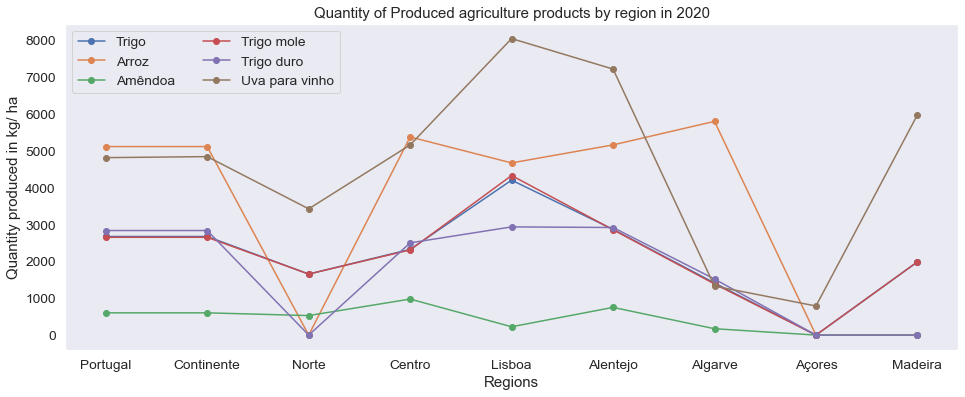

In [19]:
plt.figure(figsize=(16, 8))
df_2020=data.xs("2020", level=1)

df_2020.columns
## Obtain index of Specific Products draw those index on plot
labels_to_plot = ["Trigo", "Arroz", "Amêndoa", "Trigo mole", "Trigo duro", "Uva para vinho"]
index_to_plot = [list(df_2020.columns).index(product) for product in labels_to_plot]

# filter_col = ["Trigo", "Trigo duro", "Ananás", "Amêndoa",]
df_2020[df_2020.columns[index_to_plot]].plot(figsize=(16, 6), marker="o")
plt.title("Quantity of Produced agriculture products by region in 2020")
plt.xlabel("Regions")
plt.ylabel("Quantity produced in kg/ ha")
plt.legend(loc="upper left", ncol=2)
plt.grid()
plt.xticks(range(len(region_names)), region_names)
plt.show()
# plt.savefig("Production_2020.png")

## IPMA Notebooks
Note that the Structure of pages inside the Excel is given by:
- Shet 0 is metadata
- Shet 1 is tmin
- Shet 2 is tmax
- Shet 3 is Pluviosity

In [20]:
# Global Functions have the name in full capslock to respect pep8
# 1st Code is of the region, the second is the name of the IPMA
MAP_REGIONS_EXCEL = {
    "Norte": [11, 11],
    "Centro": [16, 132],
    "Lisboa": [17, 320],
    "Alentejo": [18, 571],
    "Algarve": [15, 554],
    "Açores": [2, 360],
    "Madeira": [3, 522],
}
IPMA_COLUMNS = ["Tmin", "Tmax", "Prec", "TmaxA", "TminA", "Prec_max", "Prec_min"]

In [21]:
def add_extra_col(meteo_coln, sheet_number):
    sheet_number += 1  # So that 1 is the Tmin, 2 is the Tmax and 3 is the precipitation
    index_describe = 2  # Mean

    if meteo_coln == "TmaxA":
        # Meaning T Max Ablsolute, so the real maximum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 2  # Tmax

    elif meteo_coln == "TminA":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 1  # Tmin

    elif meteo_coln == "Prec_min":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 3  # Precipitation Sheet

    elif meteo_coln == "Prec_max":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 3  # Precipitation Sheet

    for region, codes in MAP_REGIONS_EXCEL.items():
        meteo2 = pd.read_excel(
            f"./data_FCD/IPMA/{codes[1]}-tx-tn-prec.xlsx",
            sheet_name=sheet_number,
        )
        meteo2.dropna(axis=0, how="any", inplace=True)

        #Obtain only years after 1986
        meteo2 = meteo2[meteo2.year > 1986]
        meteo2.set_index("year", inplace=True)
        meteo2.index.names = ["Region"]
        
        # use teh Describe that gives mean (index 2), max (index 7) and min (index 3)
        data_prec = meteo2.transpose().describe()
        index_names_arr = data_prec.index.values
        
        #Rename that column to region and drop the others
        index_names_arr[index_describe] = codes[0]
        for k_name in index_names_arr:
            if k_name != codes[0]:
                data_prec.drop(index=k_name, inplace=True)
        
        years_list = data_prec.keys()
        header = [years_list, [meteo_coln] * len(years_list)]
        data_prec.columns = header
        
        data_f = (
            data_prec
            if region == list(MAP_REGIONS_EXCEL.keys())[0]
            else pd.concat([data_f, data_prec])
        )
    return data_f


In [22]:
def load_ipma():
    ipma = {
        type_data: add_extra_col(type_data, k)
        for k, type_data in enumerate(IPMA_COLUMNS)
    }
    ## Make all the concats at the same time to save time
    meteo = pd.concat([ipma[k] for k in IPMA_COLUMNS], axis=1)
    # meteo["T_range"] = meteo["TmaxA"] - meteo["TminA"]
    meteo= meteo.stack(level=0)
    meteo.index.names = ["Region", "Year"]
    return meteo.reindex(sorted(meteo.columns), axis=1)

In [23]:
meteo = load_ipma()
meteo

Prec  Prec_max  Prec_min      Tmax      TmaxA      Tmin  \
Region Year                                                                  
11     1987  136.926798     478.1      10.2  6.768706  25.200000  4.568469   
       1988  107.198616     368.5       0.0  6.188620  24.000000  4.030819   
       1989  180.122157     652.1       0.4  7.042081  27.500000  4.752958   
       1990   74.974421     253.7       5.8  7.237570  26.700000  4.807916   
       1991   96.020001     262.1      11.1  7.316523  26.600000  4.912407   
...                 ...       ...       ...       ...        ...       ...   
3      2014   39.904895     111.5       0.0  2.719779  26.807143  2.675095   
       2015   38.234384     135.1       0.0  2.809225  27.000000  2.971175   
       2016   57.553961     163.1       0.0  2.732007  28.000000  2.504345   
       2017   33.865800     104.6       0.0  2.678704  26.800000  2.547905   
       2018   55.442262     163.5       0.0  2.488702  26.600000  2.514850   

                 TminA  
Region Year             
11     1987   0.200000  
       1988   0.700000  
       1989   0.300000  
       1990   0.600000  
       1991  -0.600000  
...                ...  
3      2014  13.832143  
       2015  13.300000  
       2016  14.100000  
       2017  14.200000  
       2018  13.500000  

[209 rows x 7 columns]

## Correlation between our columns of Meterologic Data
Here we can see a high correlation between `Prec` and `Prec_max` and between the `Tmax`and `Tmin` and `TminA` we can also see some correlation

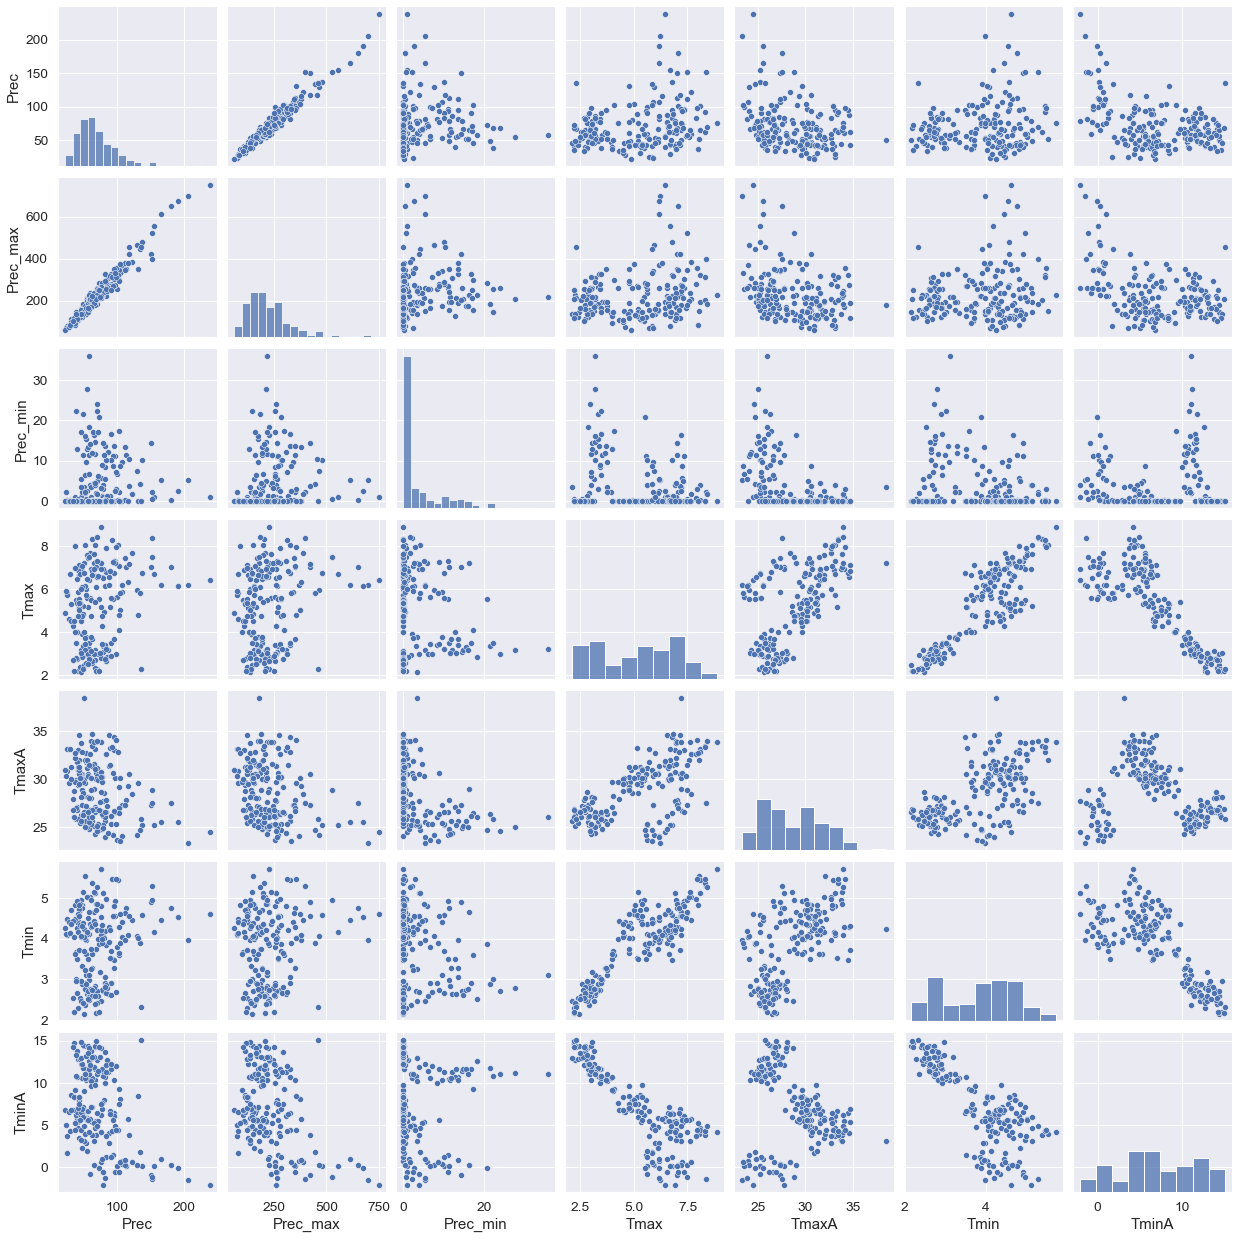

In [24]:
# A pairplot between all the meteo data that we are obtaining
sns.pairplot(meteo)
plt.show()

In [25]:
filter_col = ["Trigo", "Amêndoa"]

year = range(1986, 2022)
df_alentejo_trig_amend = {
}
for k_col, col in enumerate(filter_col):
    if col not in df_alentejo_trig_amend:
        df_alentejo_trig_amend[col] = []
    for elem in data[col]["18"]:
        df_alentejo_trig_amend[col].append(elem)

meteo_data = {}
meteo_region=meteo.xs(18)
col_to_draw = ["Prec_max"]
for k_col, col in enumerate(col_to_draw):
    if col not in meteo_data:
        meteo_data[col] = []
    for elem in meteo_region[col]:
        meteo_data[col].append(elem)
    meteo_data["year"] = meteo_region[col].index
    
for key in df_alentejo_trig_amend:
    df_alentejo_trig_amend[key] = MaxAbsScaler().fit_transform(np.array(df_alentejo_trig_amend[key]).reshape(-1, 1))

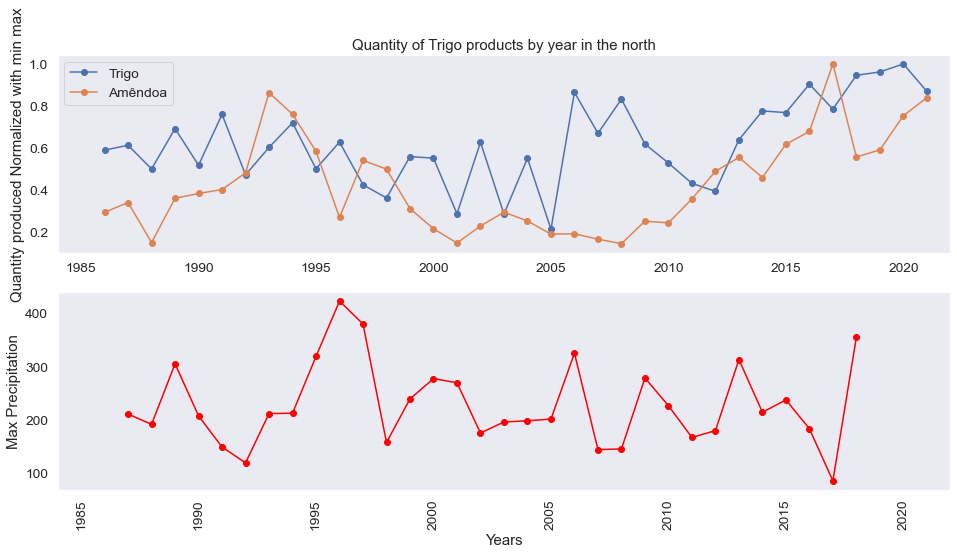

In [26]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
for key in df_alentejo_trig_amend:
    ax.plot(year, df_alentejo_trig_amend[key], label=key, marker="o")
ax2.plot(meteo_data["year"], meteo_data["Prec_max"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Max Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

## Study of the Correlation between the Meteorologic Data and the production of Trigo for the North of Portugal
To do this we have first selected only the years that are common to both datasets, and then we have ploted the correlation

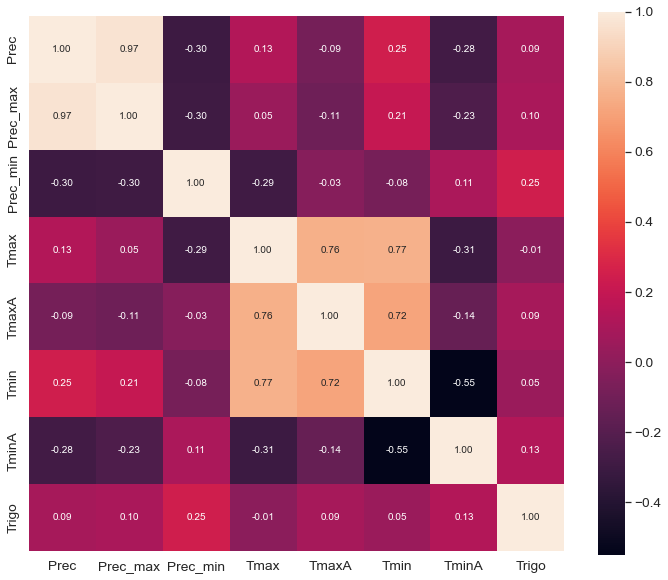

['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'Trigo']


In [27]:
meteo_region = meteo.xs(11)
data_region = data.xs("11")
index_to_plot= ["Trigo"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols.append("Trigo")
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
# cols = cols.drop('Transported')
print(cols)

InvalidIndexError: (slice(None, None, None), None)

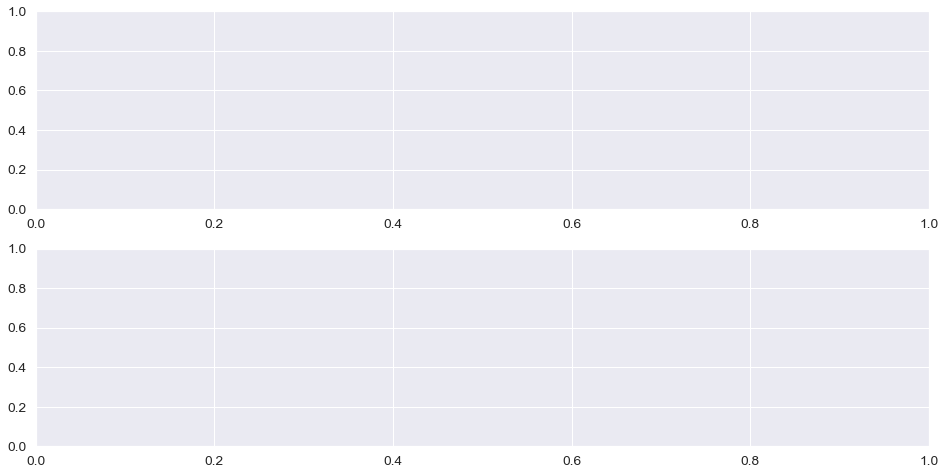

In [28]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
year = range(1987, 2019)
ax.plot(year, data_region, label="Trigo", marker="o")
ax2.plot(year, meteo_region["Prec_min"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Min Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
meteo_region = meteo.xs(11)
data_region = data.xs("11")
index_to_plot= ["Trigo", "Amêndoa", "Ananás", "Trigo duro", "Trigo mole"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols += index_to_plot
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
# cols = cols.drop('Transported')
print(cols)

In [ ]:
def table_corre(max_year=2010, delta=0, region=None):
    if region is None:
        region = [11, 16, 18, 15, 3, 2, 17]
    print(f'{"Region":<10}{"Correlation value":>20} {"Meteo":>20} {"Product":>40}')
    for region_code in region:
        meteo_region = meteo.xs(region_code)
        data_region = data.xs(str(region_code))
        index_min = list(meteo_region.index).index(1987)
        index_max = list(meteo_region.index).index(max_year)
        meteo_region = meteo_region.iloc[range(index_min+delta,index_max+delta)]

        index_min = list(data_region.index).index("1987")
        index_max = list(data_region.index).index(str(max_year))
        data_region = data_region.iloc[range(index_min,index_max)]

        cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
        list_nomes = list(meteo_region.columns)
        list_nomes.extend(data_region.columns)

        for k, sub_cm in enumerate(cm):
            if k <= 7:
                for k2, elem2 in enumerate(sub_cm):
                    if abs(elem2) > 0.6 and k2 > 7:
                        print(f"{str(region_code)}{' ':>10}{elem2:>20}{list_nomes[k]:>20}{list_nomes[k2]:>40}")

In [ ]:
table_corre(max_year=2010, delta=1)

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
region_code = 18
meteo_region = meteo.xs(region_code)
data_region = data.xs(str(region_code))
products = ["Azeitona de mesa"] #, "Figo", "Uva de mesa", "Principais leguminosas secas"]
index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(max_year)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index(str(max_year))
data_region = data_region[products].iloc[range(index_min,index_max)]

year = range(1987, max_year)
ax.plot(year, data_region, label=products, marker="o")
year = range(1987-1, max_year-1)
ax2.plot(year, meteo_region["Prec_max"], color="red", marker="o")
ax2.set_xlim([1984, max_year])
ax.set_xlim([1984, max_year])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Prec_max")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the Madeira")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
table_corre(max_year=2008, delta=0)

In [32]:
def meteo_data_region(region_code=11, min_year=1997, max_year=2010, products=["Trigo"], delta=0):
    meteo_region = meteo.xs(region_code)
    data_region = data.xs(str(region_code))
    index_min = list(meteo_region.index).index(min_year)
    index_max = list(meteo_region.index).index(max_year)
    meteo_region = meteo_region.iloc[range(index_min,index_max)]

    index_min = list(data_region.index).index(str(min_year))
    index_max = list(data_region.index).index(str(max_year))
    data_region = data_region[products].iloc[range(index_min+delta,index_max+delta)]
    year = range(1987, max_year)
    return year, data_region, meteo_region

NameError: name 'products' is not defined

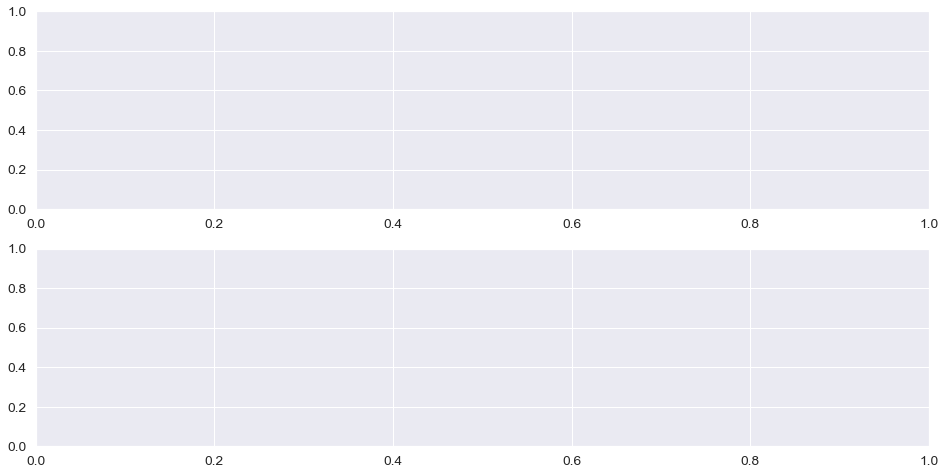

In [33]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))



ax.plot(year, data_region, label=products, marker="o")
ax2.plot(year, meteo_region["Tmax"], color="red", marker="o")
ax2.set_xlim([1984, max_year])
ax.set_xlim([1984, max_year])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Tmax")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the Madeira")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

In [34]:
year, data_region, meteo_region = meteo_data_region(region_code=11, min_year=1988, max_year=2005, products=["Batata de sequeiro"])
data_region.index = data_region.index.map(str)
meteo_region.index = meteo_region.index.map(str)
df = meteo_region.join(data_region)
df

,Prec,Prec_max,Prec_min,Tmax,TmaxA,Tmin,TminA,Batata de sequeiro
Year,,,,,,,,
1988,107.198616,368.5,0.0,6.188620,24.0,4.030819,0.7,7341
1989,180.122157,652.1,0.4,7.042081,27.5,4.752958,0.3,7426
1990,74.974421,253.7,5.8,7.237570,26.7,4.807916,0.6,7121
1991,96.020001,262.1,11.1,7.316523,26.6,4.912407,-0.6,6490
1992,59.543480,237.6,4.0,5.600812,25.2,4.353499,-0.8,8714
1993,129.382965,466.5,7.5,5.941839,24.1,4.072264,0.3,8332
1994,99.705768,254.6,6.6,5.616750,23.6,3.787649,0.1,8793
1995,133.804664,446.4,4.2,5.838327,24.7,3.895248,1.8,8839
1996,155.079259,553.6,0.9,6.702029,25.2,4.165406,0.1,7896


In [ ]:
sns.regplot(data=df, x="Prec_max", y="Batata de sequeiro")


In [ ]:
year, data_region, meteo_region = meteo_data_region(region_code=18, min_year=1990, max_year=2009, products=["Azeitona de mesa"], delta=1)
data_region.index = data_region.index.map(str)
meteo_region.index = meteo_region.index.map(str)
df = meteo_region.join(data_region)
sns.regplot(data=df, x="Prec_max", y="Azeitona de mesa", fit_reg=True)
for line in range(df.shape[0]):
     plt.text(df["Prec_max"][line]+0.2, df["Azeitona de mesa"][line], df.index[line], horizontalalignment='left', size=10, color='black', weight='semibold')

## PCA for meteo data
Trying to study similarities between the years in terms of their metereological data

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca1=PCA(n_components=2)

In [47]:
meteo_scaled=StandardScaler().fit_transform(meteo_region)
principalComponents = pca1.fit_transform(meteo_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [48]:
meteo_pca = pca1.transform(meteo_scaled)

In [49]:
pca1.explained_variance_ratio_

array([0.40680583, 0.33710063])

Our PCA covers around 74% of the variance of the data which is not very good. Still, it may be interesting to try to visualize some similarities using these two principal components (with 3 principal components we would cover 86%).

In [91]:
print(meteo_region.columns)
print(pca1.components_)

Index(['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA'], dtype='object')
[[-0.46417594 -0.45270191  0.38670316  0.30491363  0.47769545  0.26694071
   0.19400964]
 [-0.35126248 -0.35797849  0.05383251 -0.46238376 -0.28906623 -0.53901879
   0.39707536]]


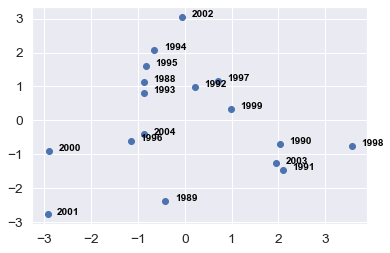

In [92]:
# Plotting the results
plt.scatter(meteo_pca[:,0], meteo_pca[:,1], label=labels)
for line, label in enumerate(labels):
     plt.text(meteo_pca[:,0][line]+0.2, meteo_pca[:,1][line], label, horizontalalignment='left', size=10, color='black', weight='semibold')

One of the things we can observe in the figure above is that the meteorological data of a certain year can be very different from the previous year.